# Implement Evaluation metric (utility score)

In [32]:
# Load modules
import numpy as np
import pandas as pd
import xgboost as xgb
import janestreet

**Utility score**

$ u = min(max(t,0), 6)* \sum{p_i}$


<br/>

**Annualized sharpe ratio:**

* $ t = \frac{\sum p_i }{\sqrt{\sum p_i^{2}}} * \sqrt{\frac{250}{\left | i \right |}}$

<br/>

**Profit per date i:**

* $ p_i = \sum_{j}^{} (weight_ij * resp_ij * action_ij)$

<br/>
where |i| is the number of unique dates in the test set

In [35]:
valid_df = pd.read_csv("../datasets/valid/valid_last_50_days.csv")
submission_df = pd.read_csv("../datasets/submission-files/submission_valid_last_50_days.csv")

assert len(valid_df) == len(submission_df)

In [38]:
valid_df[["ts_id","date", "weight", "resp"]].head()

,ts_id,date,weight,resp
0,2112176,450,0.097428,-0.000529
1,2112177,450,0.000000,0.016989
2,2112178,450,0.651918,-0.003983
3,2112179,450,0.000000,-0.013215
4,2112180,450,3.784365,-0.000527


In [36]:
submission_df.head()

,ts_id,action
0,2112176,0
1,2112177,0
2,2112178,0
3,2112179,0
4,2112180,0


In [55]:
def utility(valid_df, submission_df) :
    """
    Fast imlementation of the evaluation metric (utility score)
    
    Arguments
    ------------
    
    valid_df   : validation data frame with columns ts_id, date, weight, resp
    submission : ts_id, action 
    
    
    Return
    ---------
    - utility score 
    - t (annualized sharpe ratio)
    - Σpi (total profit)
    - pi (profit per day)
    
    
    """
    
    # From valid df keep only usefull columns and merge submission file to it
    valid_df = valid_df[["ts_id", "date", "weight", "resp"]].merge(submission_df, on="ts_id", how="left")
    
    # Calulate profit for specific ts_id wrt action (trade)
    valid_df["profit"] = valid_df["weight"] * valid_df["resp"] * valid_df["action"]
    
    
    # Calculate Profit per date (pi) - return this
    profit_df = (valid_df
                 .groupby("date")
                 .agg({"profit": ["sum"]}))

    profit_df.columns = ["_".join(x) for x in profit_df.columns.ravel()]
    profit_df.reset_index(inplace=True)
    
    # Calculate total profits (Σpi)
    a = sum(profit_df["profit_sum"]) 

    
    # Calculate std of profits per day (sqrt(Σpi^2))
    b = np.sqrt(sum(profit_df["profit_sum"]**2))

    # Count total number of days (|i|)
    i = profit_df["date"].nunique()
    

    # Calculate t
    t = (a/b) * np.sqrt(250/i)
    

    # Calculate utility score
    utility_score = min(max(t,0),6)*a
    
    results = {"utility_score": utility_score,
               "total_nb_of_days": i,
               "t": t,
               "a": a,
               "b": b,
               "profit_df":profit_df,
               "details": "a = Σpi | b = sqrt(Σpi^2) | profit_df: total profit per day"}

    return results

In [56]:
# Test function
utility(valid_df, submission_df)

{'utility_score': 9361.747177976697,
 'total_nb_of_days': 50,
 't': 12.569676512866973,
 'a': 1560.2911963294496,
 'b': 277.5661868557781,
 'profit_df':     date  profit_sum
 0    450   23.444081
 1    451   16.400408
 2    452   78.258666
 3    453   18.453676
 4    454   65.167986
 5    455   20.463085
 6    456   29.947889
 7    457    9.976482
 8    458   22.404476
 9    459  132.262878
 10   460   23.482094
 11   461   26.551965
 12   462   77.645267
 13   463   19.693399
 14   464   21.566155
 15   465   30.723766
 16   466   33.315739
 17   467   25.171849
 18   468   76.670458
 19   469   52.890403
 20   470   40.319342
 21   471   20.904562
 22   472   18.971141
 23   473   12.315830
 24   474   27.615416
 25   475   49.987516
 26   476   12.737471
 27   477    9.508138
 28   478   20.259667
 29   479   16.667461
 30   480    7.910881
 31   481   23.339572
 32   482   21.901841
 33   483   18.249735
 34   484   20.181851
 35   485    7.006635
 36   486   15.283073
 37   487   

## Detailed explanation

In [40]:
# From valid df keep only usefull columns and merge submission file to it
valid_df = valid_df[["ts_id", "date", "weight", "resp"]].merge(submission_df, on="ts_id", how="left")

,ts_id,date,weight,resp,action
0,2112176,450,0.097428,-0.000529,0
1,2112177,450,0.000000,0.016989,0
2,2112178,450,0.651918,-0.003983,0
3,2112179,450,0.000000,-0.013215,0
4,2112180,450,3.784365,-0.000527,0


In [41]:
# Calulate profit for specific ts_id wrt action (trade)
valid_df["profit"] = valid_df["weight"] * valid_df["resp"] * valid_df["action"]

In [42]:
valid_df.head()

,ts_id,date,weight,resp,action,profit
0,2112176,450,0.097428,-0.000529,0,-0.0
1,2112177,450,0.000000,0.016989,0,0.0
2,2112178,450,0.651918,-0.003983,0,-0.0
3,2112179,450,0.000000,-0.013215,0,-0.0
4,2112180,450,3.784365,-0.000527,0,-0.0


In [43]:
# Calculate Profit per date (pi) - return this

profit_df = (valid_df
             .groupby("date")
             .agg({"profit": ["sum"]}))

profit_df.columns = ["_".join(x) for x in profit_df.columns.ravel()]
profit_df.reset_index(inplace=True)
profit_df.head()

,date,profit_sum
0,450,23.444081
1,451,16.400408
2,452,78.258666
3,453,18.453676
4,454,65.167986


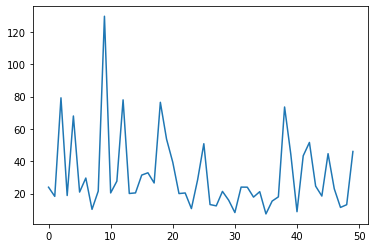

In [44]:
# Plot profit per date 
profit_df["profit_sum"].plot.line()

In [44]:
# Calculate total profits (Σpi)
a = sum(profit_df["profit_sum"]) 
a

In [45]:
# Calculate std of profits per day (sqrt(Σpi^2))
b = np.sqrt(sum(profit_df["profit_sum"]**2))
b

In [47]:
# Count total number of days (|i|)
i = profit_df["date"].nunique()
i

In [48]:
# Calculate t
t = (a/b) * np.sqrt(250/i)
t

12.569676512866973

In [49]:
# Calculate utility score
utility_score = min(max(t,0),6)*a
utility_score

9361.747177976697

## Calculate the maximum and minimum utility score (total and per date)

In [57]:
valid_df = pd.read_csv("../datasets/valid/valid_last_50_days.csv")
submission_df = pd.read_csv("../datasets/submission-files/submission_valid_last_50_days.csv")

assert len(valid_df) == len(submission_df)

In [58]:
# My submission
utility(valid_df, submission_df)["utility_score"]

9361.747177976697

In [65]:
# Best possible utility score
submission_df["action"] = (valid_df["resp"]>0).astype(int)
utility(valid_df, submission_df)["utility_score"]

26114.80494449789

In [66]:
# Worst possible utility score
submission_df["action"] = (valid_df["resp"]<0).astype(int)
utility(valid_df, submission_df)["utility_score"]

-0.0

# Create sample datasets (validation dataset, submission file)

## Create validation dataset

In [4]:
# Load data
import pandas as pd
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')
print(f'Done loading data. Train shape is {train.shape}')

Done loading data. Train shape is (2390491, 138)


In [10]:
# Create a validation dataset with last N days of the train dataset 
last_n_days = 50
days_to_keep = train["date"].unique()[-last_n_days:]
valid = train[train["date"].isin(days_to_keep)]

print(f"Days to keep {days_to_keep.shape}")
print(f"Validation's dataset dimensions {valid.shape}")

valid.head()

Days to keep (50,)
Validation's dataset dimensions (278315, 138)


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
2112176,450,0.097428,-0.000833,-0.000835,0.000108,0.000228,-0.000529,-1,-3.172026,-3.093182,...,NaN,1.821511,0.419634,1.575241,0.672071,2.251899,0.434210,1.976781,0.303244,2112176
2112177,450,0.000000,0.020888,0.027300,0.022484,0.005303,0.016989,1,-0.743662,-0.170975,...,NaN,1.589819,3.563125,0.556501,2.591933,1.023129,2.295010,1.455150,2.901352,2112177
2112178,450,0.651918,-0.001052,-0.001619,-0.003260,-0.005677,-0.003983,-1,-1.681272,-0.964650,...,NaN,-0.776762,4.241703,-0.096747,8.939113,-0.143409,7.521664,-0.121002,6.934114,2112178
2112179,450,0.000000,0.000168,0.001943,-0.001282,-0.022718,-0.013215,-1,-0.752843,-0.037552,...,NaN,-1.014563,3.512133,-0.186591,8.681816,-0.301604,7.203878,-0.780707,4.718900,2112179
2112180,450,3.784365,-0.000994,-0.002895,-0.003133,0.000731,-0.000527,1,-1.107572,-0.191019,...,NaN,-0.676558,1.898015,-0.564382,2.715748,-0.898087,2.017470,-1.037412,1.155234,2112180


In [11]:
# Save validation dataset
valid.to_csv("../datasets/valid/valid_last_50_days.csv", index = False)

## Create submission file

In [14]:
## Create a sample submission using a previously created model
import joblib
model = joblib.load("../models/xgboost_v0.joblib.dat")
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=500, n_jobs=10, num_parallel_tree=1,
              random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='hist', validate_parameters=1,
              verbosity=2)

In [17]:
# Check all the available attributes of the trained model

print("model parameters:", dir(model))
print(f"Number of Features is {model.n_features_in_}")
feature_names = model.get_booster().feature_names
feature_names

model parameters ['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_n_features', '_estimator_type', '_features_count', '_get_param_names', '_get_tags', '_le', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'apply', 'base_score', 'booster', 'classes_', 'coef_', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'evals_result', 'feature_importances_', 'fit', 'gamma', 'get_booster', 'get_num_boosting_rounds', 'get_params', 'get_xgb_params', 'gpu_id', 'importance_type', 'interaction_constraints', 'intercept_', 'kwargs', 'learning_rate', 'load_model', 'max_delta_step', 'max_depth', 'min_child_weight',

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'fea

In [19]:
# Keep only necessary columns for prediction
X_valid = valid[feature_names].copy()
X_valid.fillna(999, inplace = True)

preds = model.predict_proba(X_valid)
print(preds)

probability_for_action = preds[:,1]
print(probability_for_action)

[[0.84023947 0.15976053]
 [0.67122614 0.32877383]
 [0.59910345 0.40089658]
 ...
 [0.54661167 0.45338836]
 [0.69001544 0.30998456]
 [0.51245034 0.48754966]]
[0.15976053 0.32877383 0.40089658 ... 0.45338836 0.30998456 0.48754966]


In [24]:
# Create actions based on probabilities for action
action = (probability_for_action>0.6).astype(int)
action

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# Print predicted actions
import collections
print(f"Total actions: {dict(collections.Counter(action))}")

x = collections.Counter(action)
total = len(action)
for key in x:
    x[key] /= total
    
print(f"Percentage of actions: {dict(x)}")

Total actions: {0: 238919, 1: 39396}
Percentage of actions: {0: 0.8584481612561307, 1: 0.14155183874386937}


In [27]:
# Create submission file
submission_valid = pd.DataFrame({"ts_id": valid["ts_id"],
                                 "action": action})

In [28]:
submission_valid.shape

(278315, 2)

In [29]:
submission_valid.head()

,ts_id,action
2112176,2112176,0
2112177,2112177,0
2112178,2112178,0
2112179,2112179,0
2112180,2112180,0


In [31]:
# Save submission file
submission_valid.to_csv("../datasets/submission-files/submission_valid_last_50_days.csv", index=False)